In [1]:
import numpy as np
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from uncertainties import unumpy as unp
from uncertainties import ufloat, umath

from options import *
from constants import *

nom_vals = unp.nominal_values
std_devs = unp.std_devs

mpl.rcParams.update(rcParams)

In [2]:
# ==== Data ====
bins = np.arange(1, 2049)
cs137 = np.loadtxt("../data/cs137_G20.TKA")
co57 = np.loadtxt("../data/co57_G20.TKA")
pb210 = np.loadtxt("../data/pb210_G20.TKA")
hf181 = np.loadtxt("../data/hf181_G20.TKA")

# plt.plot(bins, hf181, ls='none', marker='x', ms=2)
# plt.ylim(0,400)

In [3]:
def gauss(x, A, mu, sigma):
    return A * np.exp(-(x-mu)**2/(2*sigma**2))

In [4]:
def get_values(bins, counts, start=0, stop=-1, p0=[200.0, -1, 50.0], plot=True, source=''):
    p0[1] = (stop-start) / 2 if p0[1] == -1 else p0[1]
    (A, mu, sigma), pcov = sc.optimize.curve_fit(gauss, bins[start:stop], counts[start:stop], p0=p0, method='dogbox')
    coefs_err = unp.uarray((A, mu, sigma), np.sqrt(np.diag(pcov)))
    if plot:
        # Peak
        plt.plot(bins[start:stop], counts[start:stop], ls='none', marker='x', ms=2)
        plt.xlabel('Channel')
        plt.ylabel('Count') # lettre?
        plt.title(source)
        plt.axvline(mu, label=f'Peak at {mu:.1f}')
        plt.legend()
        plt.show()

        # Spectre avec fit gaussian sur peak
        plt.xlabel('Channel')
        plt.ylabel('Count') # lettre?
        plt.title(source)
        x = np.linspace(0, 2048, 400)
        y = gauss(x, A, mu, sigma)
        plt.plot(x, y)
        plt.plot(bins, counts, ls='none', marker='x', ms=2)
        plt.axvline(mu, label=f'Peak at {mu:.1f}')
        plt.legend()
        plt.show()
    return coefs_err

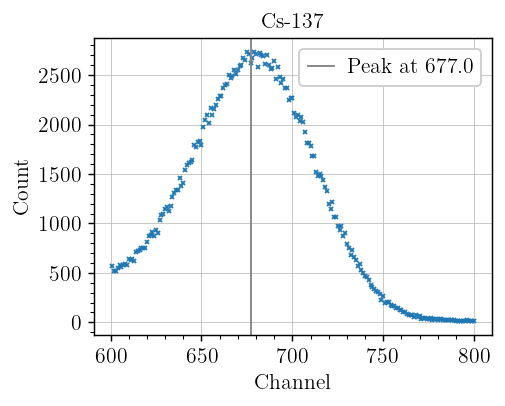

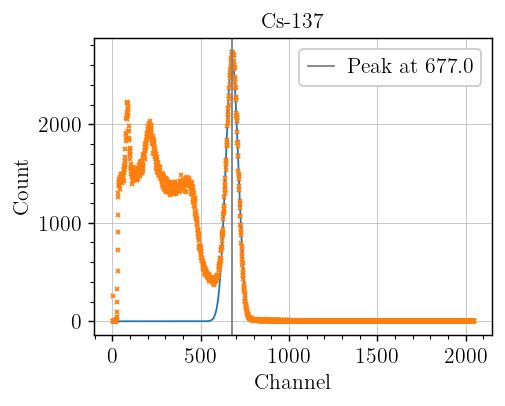

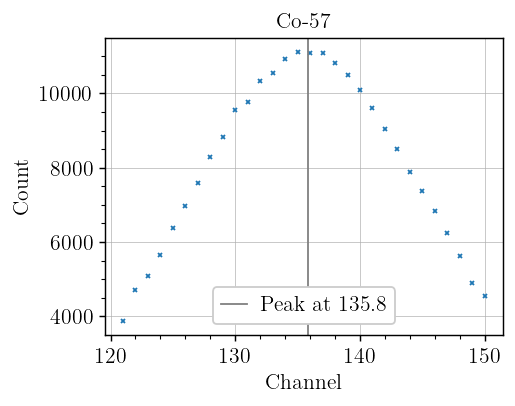

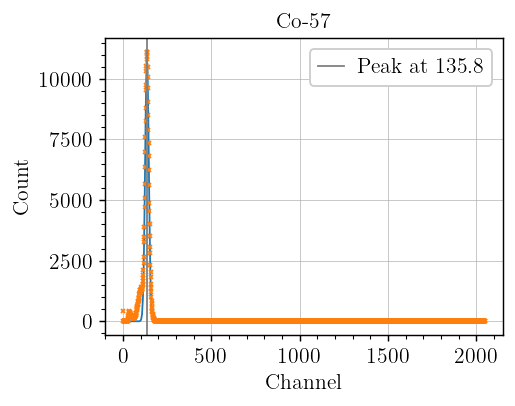

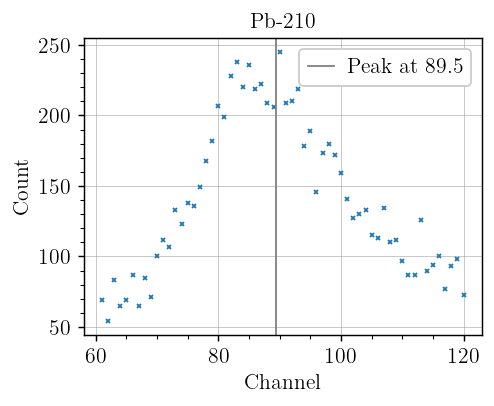

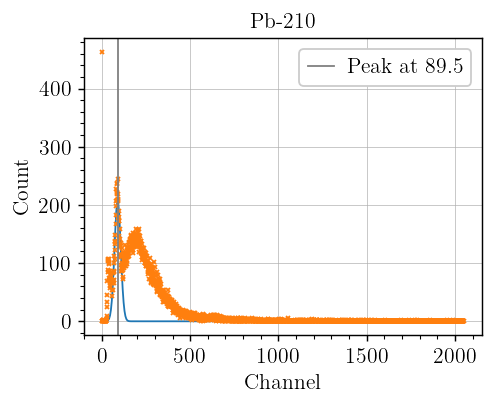

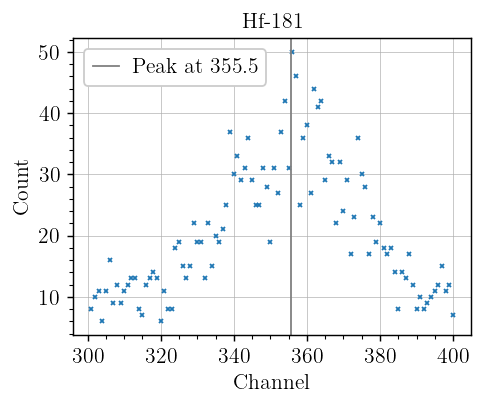

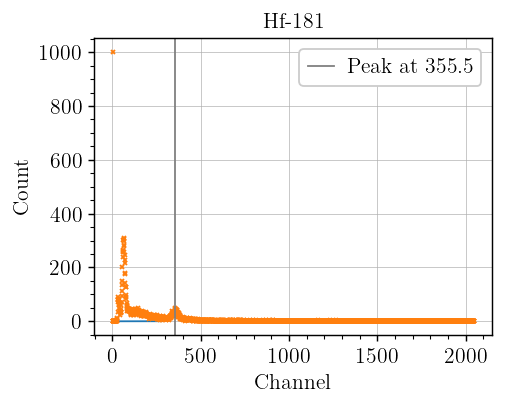

In [5]:
_, x_pic_cs137, sigma_pic_cs137 = get_values(bins, cs137, 600, 800, p0=[600, 700, 100], source='Cs-137')
_, x_pic_co57, sigma_pic_co57 = get_values(bins, co57, 120, 150, p0=[1.0, 130, 1.0], source = 'Co-57')
_, x_pic_pb210, sigma_pic_pb210 = get_values(bins, pb210, 60, 120, source='Pb-210')
_, x_pic_hf181, sigma_pic_hf181 = get_values(bins, hf181, 300, 400, source='Hf-181')

In [6]:
peak_err = unp.uarray(
    (
        x_pic_cs137.n,
        x_pic_co57.n,
        x_pic_pb210.n,
        x_pic_hf181.n
    ),
    (
        sigma_pic_cs137.n,
        sigma_pic_co57.n,
        sigma_pic_pb210.n,
        sigma_pic_hf181.n
    )
)
x = unp.nominal_values(peak_err)
dx = unp.std_devs(peak_err)
y = np.array([
    GAMMA_CS137,
    GAMMA_CO57,
    GAMMA_PB210,
    GAMMA_HF181
])

coefs, cov = np.polyfit(x, y, deg=1, cov=True, w=1/dx)
coefs_err = unp.uarray(coefs, np.sqrt(np.diag(cov)))

with open('../data/energy_calibration_coefs.csv', 'w') as f:
    f.seek(0)
    f.write(f"{coefs_err[0]},{coefs_err[1]}")
    f.truncate()

fitfunc = np.poly1d(coefs)
# Check coherence
print(fitfunc(peak_err))
# print(peak_err)



[672.8597005058386+/-36.52700594207104
 114.63508957402122+/-10.694358259901446
 66.81745264594551+/-18.060687457097377
 341.29327511892484+/-26.10764811858438]


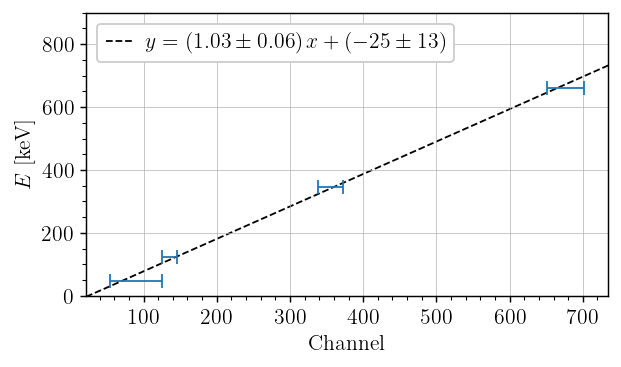

In [7]:
# Plot Calibration energie
# Plot options
p = plt.rcParams
p["figure.figsize"] = (12*INCH_PER_CM, 7*INCH_PER_CM) # a bit less than half \textwidth
p['savefig.bbox'] = 'standard'
p["figure.subplot.left"]   = 0.12
p['figure.subplot.right']  = 0.97
p['figure.subplot.top']    = 0.97
p['figure.subplot.bottom'] = 0.18
sort_index = np.argsort(x)
x = x[sort_index]
y = y[sort_index]

plt.errorbar(x, y, xerr=dx, 
             ls='', c='C0')
old_xlim = plt.xlim()
x_fit = np.linspace(*plt.xlim(), 20)
plt.plot(x_fit, fitfunc(x_fit), 
         label=r'$y = {:.1upL} x + {:.2upL}$'.format(*coefs_err),
         c='black', ls='--', zorder=0)

plt.xlim(old_xlim)
plt.ylim(0, 900)
plt.xlabel(r'Channel')
plt.ylabel(r'$E$ [keV]')

plt.legend(loc='upper left')
plt.savefig('../figures/calibration_energy.pdf')

In [8]:
energy = fitfunc(bins)
DeltaV = energy[1] - energy[0]

In [9]:
def plot_spectrum(data: np.ndarray, peaks: dict = {}, annotations: dict = {}, cs: bool = False):
    """
    Plots the given energy spectrum.
    To annotate peaks pass a dictionary of the following form:
    > {text of the annotation : ((x of arrowhead,y of arrowhead),(x of text, y of text))}
    """
    p = plt.rcParams
    p["figure.figsize"] = (8*INCH_PER_CM, 7*INCH_PER_CM) # a bit less than half \textwidth
    p['savefig.bbox'] = 'standard'
    p["figure.subplot.left"]   = 0.23
    p['figure.subplot.right']  = 0.98
    p['figure.subplot.top']    = 0.97
    p['figure.subplot.bottom'] = 0.18
    # only half of energy spectrum
    idx = energy.shape[0] // 2
    # plt.plot(unp.nominal_values(energy[5:idx]), (data[5:idx]), # Version ligne
    #          ls='None', marker='.', markersize=1, c='k')
    # plt.plot(unp.nominal_values(energy[5:idx]), (data[5:idx]), # Version ligne et marker
    #          lw=0.5, c='k', marker='.', markersize=1)
    plt.plot(unp.nominal_values(energy[5:idx]), (data[5:idx]), # Version marker
             ls='None', c='C0', marker='.', markersize=1)

    # smooth_data = sc.signal.savgol_filter(data, 100, 3)
    # for idx in sc.signal.find_peaks(smooth_data, prominence=2, width=10, height=25)[0]:
    #     plt.axvline(energy[idx])
    #     print(energy[idx])
    # for key, val in peaks.items():
    #     plt.axvline(val, label=key, c='r')
    for key, val in annotations.items():
        plt.annotate(key, *val, arrowprops=dict(arrowstyle="-", lw=0.75), fontsize=10)


    plt.xlabel(r'$E$ [keV]')
    plt.ylabel(r'N')
    # plt.legend()

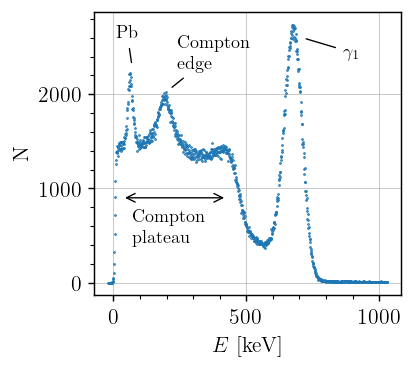

In [10]:
plot_spectrum(cs137, peaks={
    # r'Pb ???': 60,
    # r'Backscatter': 200,
    # r'Compton edge': 415,
    # r'$\gamma_{1}$': GAMMA_CS137,
}, annotations={
    r'$\gamma_{1}$' : ((GAMMA_CS137+50, 2600), (GAMMA_CS137 + 200, 2400)),
    r'Compton\\edge'  : ((210, 2050) , (240, 2500)),
    r'Pb'           : ((70, 2300), (10, 2600))
}, cs=True)
plt.annotate(text='', xy=(30,900), xytext=(430,900), arrowprops=dict(arrowstyle='<->', lw=0.75))
plt.text(70,650, r'Compton\\plateau',fontsize=10 )
plt.savefig('../figures/cs137_spectrum.pdf')

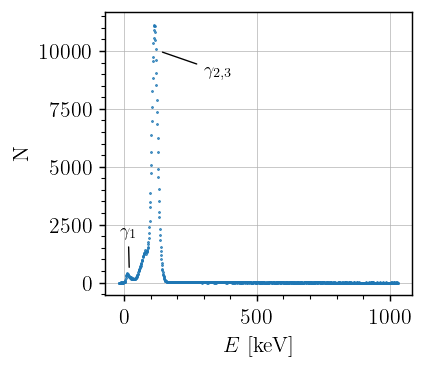

In [11]:
plot_spectrum(co57, annotations={
    r'$\gamma_1$'   : ((20, 500), (-15, 2000)),
    # r'Compton?'     : ((90, 1200), (100, 2000)),
    r'$\gamma_{2,3}$': ((GAMMA_CO57 + 10, 10000), (300, 9000)) 
})
plt.savefig('../figures/co57_spectrum.pdf')

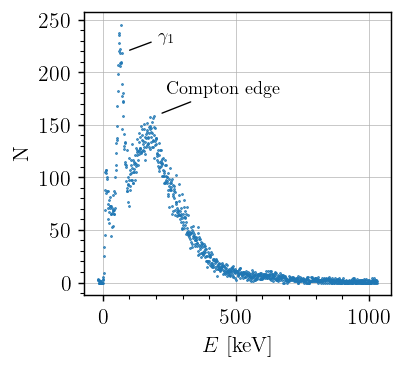

In [12]:
plot_spectrum(pb210, annotations={
    r'$\gamma_{1}$': ((energy[80]+30, 220), (energy[80] + 150, 230)),
    r'Compton edge': ((210, 160), (240, 180))
})
plt.savefig('../figures/pb210_spectrum.pdf')

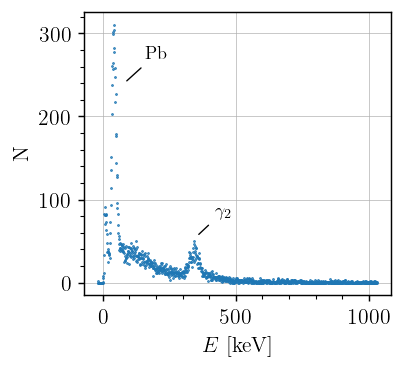

In [13]:
plot_spectrum(hf181, annotations={
    r'Pb' : ((80, 240) , (160, 270)),
    # r'$\gamma_{1}$': ((70, 305), (130, 300)),
    r'$\gamma_{2}$': ((GAMMA_HF181+5, 55), (GAMMA_HF181 + 75, 80))
})
plt.savefig('../figures/hf181_spectrum.pdf')